In [1]:
import numpy as np
from statistics import mode

dataset = np.load("mnist.npz")
x_train = dataset['x_train']
y_train = dataset['y_train']
x_test = dataset['x_test']
y_test = dataset['y_test']

# Choose samples from 0 and 1 class in X & store the true label in Y_true
X = []
Y_true = []
count = {i: 0 for i in range(2)}
for i in range(len(x_train)):
    if (y_train[i] == 0 or y_train[i] == 1):
        count[y_train[i]]+=1
        Y_true.append(y_train[i])
        X.append(x_train[i].flatten())
X_array = np.array(X)

# print(X_array.shape)
# print(len(Y_true))
# print(count)


# Divide the train set into train and val set
for i in range(len(Y_true)): # relabeling 0 as -1
    if (Y_true[i]==0):
        Y_true[i] = -1
        
val0=0
val1=0
x=[]
y=[]
x_val = []
y_val = []
count_train = {i: 0 for i in [-1,1]}
count_val = {i: 0 for i in [-1,1]}
for i in range(len(Y_true)):
    if (Y_true[i] == -1 and val0<1000):
        x_val.append(X_array[i].flatten())
        y_val.append(Y_true[i])
        val0+=1
        count_val[Y_true[i]]+=1
    elif (Y_true[i] == 1 and val1<1000):
        x_val.append(X_array[i].flatten())
        y_val.append(Y_true[i])
        val1+=1
        count_val[Y_true[i]]+=1
    else:
        x.append(X_array[i].flatten())
        y.append(Y_true[i])
        count_train[Y_true[i]]+=1
        
X_train = np.array(x)
y = np.array(y)
X_val = np.array(x_val)
y_val = np.array(y_val)

# print(X_train.shape)
# print(len(y))
# print(y.shape)
# print(count_train)

# print(X_val.shape)
# print(len(y_val))
# print(y_val.shape)
# print(count_val)

# print(y)
# print(y_val)



# Applying PCA on X_train 

mean = np.mean(X_train,axis = 0)
# print(mean)
X_array = X_train - mean # Centralized X
total_samples = len(y)

# covariance matrix
S = np.dot(X_array.T, X_array) / (total_samples-1)
# print(S.shape)

eigenvalues, eigenvectors = np.linalg.eig(S)

# Sort them in desc order on the basis of eigenvalues & create matrix U of eigenvectors
idxs = sorted([i for i in range(len(eigenvalues))], key = lambda x: -eigenvalues[x])

U = []
for i in idxs:
    U.append(eigenvectors.T[i])
    
U = np.array(U).T
# print(U.shape)
# print(X_array.shape)

p = 5
Up = U[:, :p]
# U_P Y = U_P (U_P'X)
# print(Up.shape)

# Y = U_p'X --> projected x_train i.e. dimensionally reduced dataset
Y = np.real(np.dot(Up.T, X_array.T)).T
# print(Y.shape)
# Y here is the reduced dimension dataset
Y = Y/255 # Normalizing
# print(Y)

# Y --> dimensionally reduced dataset of the x_train with dimensions 10665 X 5
# y --> true labels of samples in Y


# Applying PCA on X_val & store the true label in y_val

X_Tarray = X_val - mean
# print(X_Tarray.shape)
# print(len(y_val))

# Y = U_p'x_valtest --> projected x_valtest i.e. dimensionally reduced val dataset
Y_valtest = np.real(np.dot(Up.T, X_Tarray.T)).T
# print(Y_valtest.shape)
# Y_valtest here is the reduced dimension val test dataset
Y_valtest = Y_valtest/255 # Normalizing
# print(Y_valtest)

# Y_valtest --> dimensionally reduced dataset of the X_val with dimensions 2000 X 5
# y_val --> true labels of samples in Y_valtest


In [2]:
feature = []
midpoints_array = np.array([])
for k in range(5):
    feature = []
    for i in range(len(Y)):
        feature.append(Y[i][k])
    # print(len(feature))
    f = np.array(feature)
    sorted_f = np.sort(f)
    midpoints = (sorted_f[:-1] + sorted_f[1:]) / 2
    # print(len(midpoints))    
    midpoints_array = np.append(midpoints_array, midpoints)
# print(f)
# print(sorted_f)
# print(midpoints)  
print(midpoints_array.shape) # 10664 (total_samples - 1) each for each dimension in chronological order


(53320,)


In [3]:

# Define the shape of the outer array
outer_shape = len(midpoints_array)
inner_shape = len(Y)
# Initialize an empty array to store predictions
predictions = np.empty((outer_shape, inner_shape), dtype=int)

# Initialize an empty array to store majority values of the left and right
values = np.empty((outer_shape, 2), dtype=int)


total = len(Y)-1 # no of midpoints in each dimension
for k in range(5):
    for i in range(k*total,(k+1)*total):

        midvalue = midpoints_array[i]
        # Create masks based on the value of the kth feature
        mask_lower = Y[:, k] < midvalue
        mask_upper = Y[:, k] >= midvalue 

        # Split Y and Y_true based on the masks
        # Y_lower = Y[mask_lower]
        # Y_upper = Y[mask_upper]

        # result = (Y[:, k] >= midvalue).astype(int)
        
        
        Y_true_lower = y[mask_lower]
        Y_true_upper = y[mask_upper]    
        
        # print("Y_lower shape:", Y_lower.shape)
        # print("Y_upper shape:", Y_upper.shape)
        # print("Y_true_lower shape:", Y_true_lower.shape)
        # print("Y_true_upper shape:", Y_true_upper.shape)   

        left_value = 0
        right_value = 0   

        # For the split, we have to compute the mode for each side, then assign that to it, and then compute the miss-classification error 
        if (len(Y_true_lower)>0):
            left_value = mode(Y_true_lower)
        if (len(Y_true_upper)>0):
            right_value = mode(Y_true_upper)
        # print(f"{i} : {left_value}, {right_value}")
        # if (left_value == 0 or right_value == 0):
        #     break
        values[i, 0] = left_value
        values[i, 1] = right_value

        # Compute result array - which samples are classified(1) and mis-classified(0)
        result = np.ones(inner_shape, dtype=int)
        # For samples in the lower part
        result[mask_lower & (y == left_value)] = 0
        # For samples in the upper part
        result[mask_upper & (y == right_value)] = 0
        predictions[i, :] = result
        if (i%1000 == 0):
            print(i)
        if (i%10000 == 0):
            print(result)

0
[0 0 0 ... 0 1 0]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[0 0 0 ... 0 1 0]
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
[0 0 0 ... 0 1 0]
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
[1 0 1 ... 1 1 0]
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
[1 0 0 ... 1 1 0]
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
[0 0 0 ... 0 1 0]
51000
52000
53000


In [4]:
print(predictions.shape)
print(values.shape)
print(predictions[1])
print(predictions[1].shape)

(53320, 10665)
(53320, 2)
[0 0 0 ... 0 1 0]
(10665,)


In [5]:
best_splitindex = []
best_dimensions= []
best_splitvalues = []
best_L_i = []
alpha_i = []


weights = np.full(len(Y), 1/len(Y)) # Initial weights for each sample
# print(weights)

for t in range(300):
    
    # Compute the weighted predictions for each split
    weighted_predictions = predictions * weights
    # print(weighted_predictions.shape)
    # Compute the total weighted predictions for each split
    total_weighted_predictions = np.sum(weighted_predictions, axis=1)
    total_weight = np.sum(weights)   
    # print(total_weight)
    result = (1/total_weight) * total_weighted_predictions
    # print(total_weighted_predictions.shape)
    # print(result.shape)
    best_split_index = np.argmin(result)
    best_splitindex.append(best_split_index)
    dim = best_split_index//total
    best_dimensions.append(dim)
    best_split_value = midpoints_array[best_split_index]
    best_splitvalues.append(best_split_value)
    min_L = result[best_split_index]
    best_L_i.append(min_L)
    alpha = np.log((1 - min_L) / min_L)
    alpha_i.append(alpha)
    # Update weights
    indicator = (predictions[best_split_index] == 1)  # Indicator function for misclassified samples
    # print(indicator.shape)
    weights *= np.exp(alpha * indicator)
    # print(weights.shape)
    # print(weights)
    # print(sum(weights))
    if (t%10 == 0):
        print(t)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [6]:
print(best_splitindex)
print(best_dimensions)
print(best_splitvalues)
print(best_L_i)
print(alpha_i)

[4916, 5286, 4632, 14702, 24770, 40153, 4632, 5286, 4632, 13135, 4632, 25994, 12632, 4755, 15228, 24138, 5286, 30152, 5286, 4632, 14723, 29711, 5286, 24775, 12632, 4632, 13135, 30474, 5286, 36260, 40153, 5286, 29711, 15039, 4632, 5286, 24775, 12632, 29711, 5286, 36260, 13324, 30808, 5286, 4632, 47727, 25384, 12632, 30359, 5286, 4632, 14723, 24138, 5286, 29262, 13324, 30827, 5286, 4632, 5286, 36260, 12632, 24775, 15197, 30152, 5286, 30152, 5286, 4632, 13324, 30152, 5286, 41505, 5286, 36260, 15197, 23948, 5286, 29711, 12632, 4632, 5286, 41505, 5286, 30125, 13324, 4632, 5286, 41505, 11559, 24791, 47727, 30474, 15197, 4632, 5286, 41505, 5286, 30016, 11559, 23948, 13324, 30359, 5286, 36260, 5286, 41505, 11559, 4632, 12632, 30359, 5286, 41505, 15197, 24778, 5286, 30016, 5286, 41505, 5286, 4632, 13324, 30016, 5286, 36260, 11559, 41505, 15197, 30016, 5286, 4632, 5286, 41505, 5286, 30016, 5286, 41505, 11559, 24778, 15197, 30359, 5286, 4632, 13021, 30016, 5286, 41505, 5286, 36260, 12632, 30359, 

In [7]:
no_of_trees = 300
total_val = len(y_val)
val_predictions = np.empty((no_of_trees, total_val))
val_accuracy = []
# Y_valtest --> dimensionally reduced dataset of the X_val with dimensions 2000 X 5
# y_val --> true labels of samples in Y_valtest

for t in range(no_of_trees):
    
    # Create masks based on the value of the dim th feature
    mask_lower = Y_valtest[:, best_dimensions[t]] < best_splitvalues[t]
    mask_upper = Y_valtest[:, best_dimensions[t]] >= best_splitvalues[t]
    
    # Compute prediction array - what are the predictions for the val set by h_i(x)
    predict = np.empty(total_val, dtype=int)
    # For samples in the lower part
    predict[mask_lower] = values[best_splitindex[t]][0]
    # For samples in the upper part
    predict[mask_upper] = values[best_splitindex[t]][1]
    
    sign_predict = alpha_i[t]*predict
    val_predictions[t] = sign_predict

    cumulative_sum = np.sum(val_predictions[:t+1], axis=0)
    val_predict = np.sign(cumulative_sum)
    
    correct_predictions = (val_predict == y_val)
    # Count the number of correct predictions
    count_correct = np.sum(correct_predictions)
        
    # print(count_correct)
    accuracy = count_correct*100/total_val
    # print(accuracy)
    val_accuracy.append(accuracy)

In [8]:
print(val_accuracy)

[99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.55, 99.6, 99.55, 99.6, 99.55, 99.6, 99.55, 99.6, 99.6, 99.6, 99.6, 99.6, 99.55, 99.55, 99.55, 99.55, 99.55, 99.55, 99.55, 99.55, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.55, 99.55, 99.55, 99.55, 99.55, 99.55, 99.55, 99.55, 99.55, 99.55, 99.65, 99.65, 99.7, 99.7, 99.65, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.65, 99.7, 99.65, 99.7, 99.65, 99.7, 99.65, 99.7, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65, 99.65

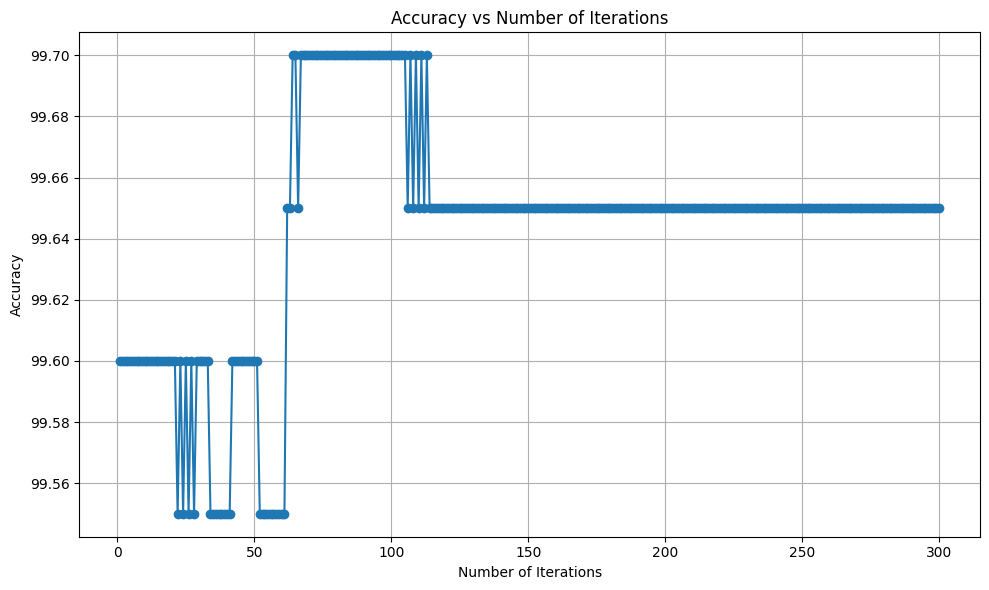

In [9]:
import matplotlib.pyplot as plt
iterations = np.arange(1, no_of_trees+1)
plt.figure(figsize=(10, 6))
plt.plot(iterations, val_accuracy, marker='o', linestyle='-')
plt.title('Accuracy vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
val_accuracy = np.array(val_accuracy)
max_value = np.max(val_accuracy)
# Find all indices where the value is equal to the maximum value
max_indices = np.argwhere(val_accuracy == max_value).flatten()
max_index = np.max(max_indices)
print(f"Maximum Val Set Accuracy = {max_value}% at {max_index+1} iterations")
print("Indices of maximum value:", max_indices)
print("Boosted tree with maximum val accuracy: ", max_index+1)

Maximum Val Set Accuracy = 99.7% at 113 iterations
Indices of maximum value: [ 63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 106 108 110 112]
Boosted tree with maximum val accuracy:  113


In [27]:
X_T =[]
Y_test_true = []
for i in range(len(x_test)):
    if (y_test[i] == 0 or y_test[i] == 1):
        Y_test_true.append(y_test[i])
        X_T.append(x_test[i].flatten())
X_Test = np.array(X_T)
X_Test = X_Test - mean
print(X_Test.shape)
print(len(Y_test_true))

for i in range(len(Y_test_true)): # relabeling 0 as -1
    if (Y_test_true[i]==0):
        Y_test_true[i] = -1

Y_True = np.array(Y_test_true)

# Y = U_p'x_test --> projected x_test i.e. dimensionally reduced test dataset
Y_test = np.real(np.dot(Up.T, X_Test.T)).T
print(Y_test.shape)
# Y_test here is the reduced dimension test dataset
Y_test = Y_test/255 # Normalizing

# Y_test --> dimensionally reduced dataset of the X_Test with dimensions 2000 X 5
# Y_True --> true labels of samples in Y_Test


(2115, 784)
2115
(2115, 5)


In [28]:
# Testing Best boosted tree on Test Set
total_test = len(Y_True)
test_predictions = np.empty((max_index, total_test))

for t in range(max_index):
    # Create masks based on the value of the dim th feature
    mask_lower = Y_test[:, best_dimensions[t]] < best_splitvalues[t]
    mask_upper = Y_test[:, best_dimensions[t]] >= best_splitvalues[t]
    
    # Compute prediction array - what are the predictions for the val set by h_i(x)
    predict = np.empty(total_test, dtype=int)
    # For samples in the lower part
    predict[mask_lower] = values[best_splitindex[t]][0]
    # For samples in the upper part
    predict[mask_upper] = values[best_splitindex[t]][1]
    
    sign_predict = alpha_i[t]*predict
    test_predictions[t] = sign_predict

cumulative_sum = np.sum(test_predictions[:max_index+1], axis=0)
test_predict = np.sign(cumulative_sum)
    
correct_predictions = (test_predict == Y_True)
# Count the number of correct predictions
count_correct = np.sum(correct_predictions)
        
print(count_correct)
accuracy = count_correct*100/total_test
print(accuracy)

2111
99.81087470449172
